In [38]:
# Common imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [39]:
# Import from utils
import sys
import importlib
sys.path.append('../')

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\USUARIO\\Desktop\\Projects\\4Geeks_temporal_series\\src\\aquifer\\..\\utils.py'>

# Combinación de datasets para el modelo

In [40]:
files = {
    "Aquifer_Auser": "../../data/processed/aquifer_auser.csv",
    "Aquifer_Doganella": "../../data/processed/aquifer_doganella.csv",
    "Aquifer_Luco": "../../data/processed/aquifer_luco.csv",
    "Aquifer_Petrignano": "../../data/processed/aquifer_petrignano.csv",
}

In [41]:
dfs = []
for name, path in files.items():
    df = pd.read_csv(path)
    df["Acuifero"] = name
    
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

    # Verificar si hay fechas NaT y reportarlo
    if df["Date"].isna().sum() > 0:
        print(f"Advertencia: {df['Date'].isna().sum()} valores NaT en el dataset {name}")

    dfs.append(df)

In [42]:
combined_df = pd.concat(dfs, ignore_index=True)

if combined_df["Date"].isna().sum() > 0:
    print(f"Aún hay {combined_df['Date'].isna().sum()} valores NaT en la columna Date.")

combined_df

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,1998-03-05,37.2,26.0,21.4,43.2,29.4,35.2,31.2,0.0,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-03-06,37.2,26.0,21.4,43.2,29.4,35.2,31.2,0.0,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-03-07,37.2,26.0,21.4,43.2,29.4,35.2,31.2,0.0,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-03-08,37.2,26.0,21.4,43.2,29.4,35.2,31.2,0.0,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-03-09,37.2,26.0,21.4,43.2,29.4,35.2,31.2,0.0,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26885,2020-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
26886,2020-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
26887,2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
26888,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4


In [43]:
combined_df.to_csv("../../data/processed/combined_aquifers.csv", index=False)

# Modelado

In [44]:
df = combined_df.sort_values(by=["Date"])

In [45]:
utils.get_null_percentage_per_column(df)

Hydrometry_Fiume_Chiascio_Petrignano       80.576422
Volume_C10_Petrignano                      80.576422
Temperature_Petrignano                     80.576422
Temperature_Bastia_Umbra                   80.576422
Depth_to_Groundwater_P25                   80.576422
Depth_to_Groundwater_P24                   80.576422
Rainfall_Bastia_Umbra                      80.576422
Rainfall_Monteporzio                       77.590182
Rainfall_Velletri                          77.590182
Temperature_Monteporzio                    77.590182
Temperature_Velletri                       77.590182
Rainfall_Montalcinello                     72.156936
Rainfall_Simignano                         72.156936
Temperature_Mensano                        72.156936
Rainfall_Sovicille                         72.156936
Temperature_Siena_Poggio_al_Vento          72.156936
Temperature_Pentolina                      72.156936
Temperature_Monteroni_Arbia_Biena          72.156936
Rainfall_Gallicano                         69.

In [46]:
# Interpolar valores nulos
df.interpolate(method='linear', limit_direction='both', inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4384\379664313.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', limit_direction='both', inplace=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4384\379664313.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_4384\379664313.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [47]:
utils.get_null_percentage_per_column(df)

Date                                       0.0
Rainfall_Gallicano                         0.0
Hydrometry_Piaggione                       0.0
Acuifero                                   0.0
Rainfall_Monteporzio                       0.0
Rainfall_Velletri                          0.0
Temperature_Monteporzio                    0.0
Temperature_Velletri                       0.0
Rainfall_Simignano                         0.0
Rainfall_Montalcinello                     0.0
Rainfall_Sovicille                         0.0
Temperature_Siena_Poggio_al_Vento          0.0
Temperature_Mensano                        0.0
Temperature_Pentolina                      0.0
Temperature_Monteroni_Arbia_Biena          0.0
Rainfall_Bastia_Umbra                      0.0
Depth_to_Groundwater_P24                   0.0
Depth_to_Groundwater_P25                   0.0
Temperature_Bastia_Umbra                   0.0
Temperature_Petrignano                     0.0
Volume_C10_Petrignano                      0.0
Hydrometry_Mo

In [48]:
# Selección de variables
target_col = "Depth_to_Groundwater_P24"  # Ajustar a la variable objetivo más representativa
feature_cols = [col for col in df.columns if col not in ["Date", "Acuifero", target_col]]

In [49]:
# Normalización
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [50]:
df

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,1998-03-05,1.453706,1.472498,1.257564,1.768593,1.365313,1.429396,1.422236,-0.316936,0.592721,...,-0.517061,-1.062834,-1.712524,-0.268702,-22.480000,0.854968,-0.790429,-0.743644,-0.042938,0.0368
1,1998-03-06,1.453706,1.472498,1.257564,1.768593,1.365313,1.429396,1.422236,-0.316936,0.592721,...,-0.517061,-1.062834,-1.712524,-0.268702,-22.480000,0.854968,-0.790429,-0.743644,-0.042938,0.0368
2,1998-03-07,1.453706,1.472498,1.257564,1.768593,1.365313,1.429396,1.422236,-0.316936,0.592721,...,-0.517061,-1.062834,-1.712524,-0.268702,-22.480000,0.854968,-0.790429,-0.743644,-0.042938,0.0368
3,1998-03-08,1.453706,1.472498,1.257564,1.768593,1.365313,1.429396,1.422236,-0.316936,0.592721,...,-0.517061,-1.062834,-1.712524,-0.268702,-22.480000,0.854968,-0.790429,-0.743644,-0.042938,0.0368
4,1998-03-09,1.453706,1.472498,1.257564,1.768593,1.365313,1.429396,1.422236,-0.316936,0.592721,...,-0.517061,-1.062834,-1.712524,-0.268702,-22.480000,0.854968,-0.790429,-0.743644,-0.042938,0.0368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,2020-06-29,-0.684502,-0.694269,-0.700739,-0.660151,-0.696003,-0.743819,-0.703585,-0.316936,-0.619914,...,2.752862,1.484558,1.074459,-0.268702,-25.823333,-0.091307,2.022229,2.122634,-0.481022,0.0368
8153,2020-06-30,-0.684502,-0.694269,-0.700739,-0.660151,-0.696003,-0.743819,-0.703585,-0.316936,-0.619914,...,2.763975,1.502516,1.111509,-0.268702,-25.845000,-0.094958,2.030817,2.133865,-0.534346,0.0368
21666,2020-06-30,-0.684502,-0.694269,-0.700739,-0.660151,-0.696003,-0.743819,-0.703585,-0.316936,-0.619914,...,2.775088,1.520475,1.148559,-0.268702,-25.866667,-0.098610,2.039405,2.145097,-0.587671,0.0368
14179,2020-06-30,-0.684502,-0.694269,-0.700739,-0.660151,-0.696003,-0.743819,-0.703585,-0.316936,-0.619914,...,2.775088,1.520475,1.148559,-0.268702,-25.888333,-0.102262,2.047994,2.156328,-0.640995,0.0368


In [51]:
# Codificación de la variable categórica "Acuifero"
label_encoder = LabelEncoder()
df["Acuifero"] = label_encoder.fit_transform(df["Acuifero"])

In [52]:
# Dividir datos en entrenamiento y prueba (80%-20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [53]:
# Preparar datos para LSTM
def create_sequences(data, target_col, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][feature_cols + ["Acuifero"]].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, target_col, seq_length)
X_test, y_test = create_sequences(test, target_col, seq_length)

In [54]:
# Construcción del modelo LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - loss: 42.0588 - val_loss: 293.0939
Epoch 2/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 2.4680 - val_loss: 358.1878
Epoch 3/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 2.3641 - val_loss: 26.5512
Epoch 4/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 2.1566 - val_loss: 39.5391
Epoch 5/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - loss: 1.7608 - val_loss: 24.6672
Epoch 6/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 1.5393 - val_loss: 18.4355
Epoch 7/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 1.2100 - val_loss: 12.3853
Epoch 8/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.8813 - val_loss: 13.1836
Epoch 9/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - loss: 0.5647 - val_loss: 0.3017
Epoch 10/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.3068 - val_loss: 1.3411
Epoch 11/50
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.1916 - val_loss: 7.13

# Evaluación del modelo

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
MAE: 4.0644, RMSE: 7.9409


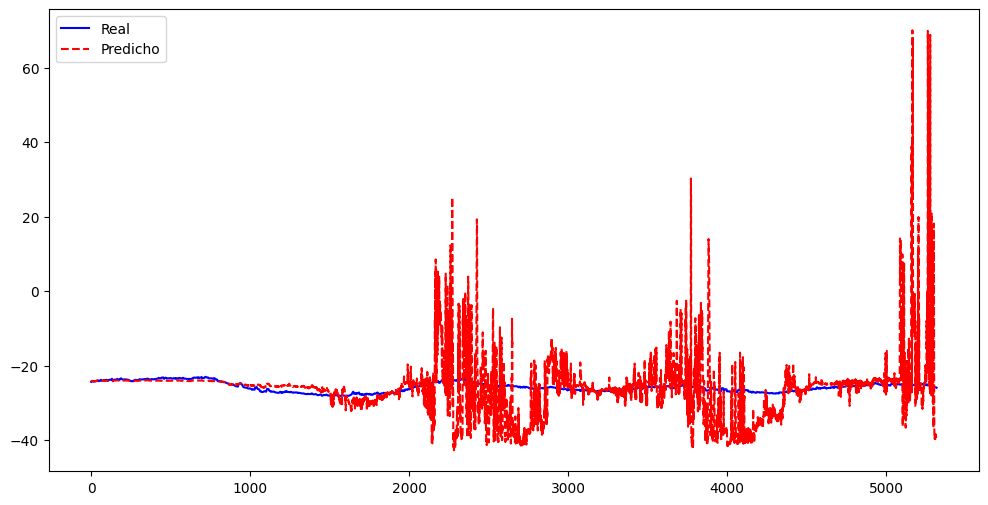

In [56]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color="blue")
plt.plot(y_pred, label="Predicho", color="red", linestyle="dashed")
plt.legend()
plt.show()
